In [1]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import astropy.units as u
import random
import pandas as pd
import copy
import json
import numba
import math
import pickle

from textwrap import fill
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.coordinates import search_around_sky
from matplotlib.patches import Rectangle
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from astropy.coordinates import angular_separation
import astropy.units as u
from astropy.table import join
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve, auc, precision_recall_curve, average_precision_score


from Constantes import SELECTED_COLUMNS_Xamin, ISCLUSTER, ISNOTCLUSTER
from Constantes import VOCAB_SIZE, PAD_TOKEN, SEP_TOKEN, CLS_TOKEN, SEP_AMAS, NOMBRE_TOKENS_SPECIAUX
from Constantes import BATCH_SIZE, D_MODEL, NUM_HEADS, NUM_LAYERS, name_dir

################################################################################
#                                                                              #
#                             Constantes utilisées                             #
#                                                                              #
################################################################################

Nombre de colonnes SELECTED_COLUMNS_Xamin: 5

Nombre de colonnes use_log_scale_Xamin: 5


In [2]:
'''X_test  = np.loadtxt(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Center_classifier/X_test.txt', dtype=int)
print(f"Nombre de sequences de test: {len(X_test)}")
print(f"len(gen_seq[0]) = {len(X_test[0])}")'''

'X_test  = np.loadtxt(f\'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Center_classifier/X_test.txt\', dtype=int)\nprint(f"Nombre de sequences de test: {len(X_test)}")\nprint(f"len(gen_seq[0]) = {len(X_test[0])}")'

In [3]:
with open(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Center_classifier/sequence_divinatio_test_full.pkl', 'rb') as f:
    gen_seq = pickle.load(f)

with open(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Center_classifier/sequence_veritas_test_full.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(f'/local/home/sh275430/Documents/Results_Project_Transformer_FornaX/Center_classifier/proba_divinatio_test_full.pkl', 'rb') as f:
    Proba_test = pickle.load(f)


X_test = np.array(X_test)
gen_seq = np.array(gen_seq)
Proba_test = np.array(Proba_test)

print(f"Nombre de sequences de test: {len(gen_seq)}")
print(f"len(gen_seq[0]) = {len(gen_seq[0])}\n")

/tmp/ipykernel_1140803/3199202358.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  gen_seq = pickle.load(f)
/tmp/ipykernel_1140803/3199202358.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the ca

Nombre de sequences de test: 27672
len(gen_seq[0]) = 19



In [4]:
X_test

array([[1026,  650,  881, ..., 1027, 1028, 1025],
       [1026,  556,  772, ..., 1027, 1028, 1025],
       [1026,  751,  724, ..., 1027, 1028, 1025],
       ...,
       [1026, 1024,  575, ..., 1027, 1029, 1025],
       [1026, 1024,  575, ..., 1027, 1029, 1025],
       [1026, 1024,  575, ..., 1027, 1029, 1025]], dtype=int32)

In [5]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])


[1026  602  585  511  511  405  562  601  282  535  172 1024 1024 1024
 1024 1024 1027 1029 1025]
[1026  602  585  511  511  405  562  601  282  535  172 1024 1024 1024
 1024 1024  765 1029 1025]


In [6]:
#////////// Load Configuration /////////
with open(f"/local/home/sh275430/Documents//Results_Project_Transformer_FornaX/Center_classifier/constantes_du_modele.json", 'r') as f:
    config = json.load(f)

MAX_SOURCES  = config["MAX_SOURCES"]
print("┌───────────────────────────────┐")
print("│  MODEL CONFIGURATION          │")
print("├───────────────────────────────┤")
for key, value in config.items():
    print(f"│ {key.ljust(15)}: {str(value).rjust(10)}   │")
print("└───────────────────────────────┘")

┌───────────────────────────────┐
│  MODEL CONFIGURATION          │
├───────────────────────────────┤
│ VOCAB_SIZE     :       1030   │
│ PAD_TOKEN      :       1024   │
│ SEP_TOKEN      :       1025   │
│ CLS_TOKEN      :       1026   │
│ SEP_AMAS       :       1027   │
│ NOMBRE_TOKENS_SPECIAUX:          6   │
│ MAX_SOURCES    :          3   │
└───────────────────────────────┘


In [7]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])


[1026  602  585  511  511  405  562  601  299  420  172 1024 1024 1024
 1024 1024 1027 1029 1025]
[1026  602  585  511  511  405  562  601  299  420  172 1024 1024 1024
 1024 1024  515 1029 1025]


In [8]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])

CLASS_POSITION = len(SELECTED_COLUMNS_Xamin)*MAX_SOURCES + 2


print(" ")
print(X_test[num_fenetre][CLASS_POSITION])

[1026  997  988  511  511  543  569  588  992  527  208 1024 1024 1024
 1024 1024 1027 1028 1025]
[1026  997  988  511  511  543  569  588  992  527  208 1024 1024 1024
 1024 1024  889 1028 1025]
 
1028


In [9]:
def get_corresponding_labels(batch_sequences, class_token_position):
    # Construction du mapping
    token_to_label = np.zeros(VOCAB_SIZE + 1, dtype=np.int32)  # Initialisé à 0 par défaut
    
    # Modification des valeurs avec NumPy standard
    token_to_label[ISCLUSTER] = 0   # ou la valeur que vous souhaitez assigner
    token_to_label[ISNOTCLUSTER] = 1
    
    # Extraction des tokens à la position spécifiée
    class_tokens = batch_sequences[:, class_token_position]
    
    # Conversion des tokens en labels
    labels = token_to_label[class_tokens]
    
    return labels

In [10]:
y_test = get_corresponding_labels(X_test, CLASS_POSITION)
print(Counter(np.array(y_test)))

y_gen_test = get_corresponding_labels(gen_seq, CLASS_POSITION)
print(Counter(np.array(y_gen_test)))

Counter({np.int32(1): 15636, np.int32(0): 12036})
Counter({np.int32(1): 24527, np.int32(0): 3145})


In [11]:
def Matrice_confusion(y_true, y_pred, jeu):
    """
    Trace une matrice de confusion avec pourcentages à partir des vrais labels et prédictions

    Args:
        y_true: Vecteur des vraies classes (0=AMAS, 1=AGN)
        y_pred: Vecteur des classes prédites
        jeu: Nom du jeu de données pour le titre
    """

    plt.style.use("default")
    plt.rcParams['text.usetex'] = True

    # Convertir en numpy array si ce sont des DeviceArray JAX
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Labels correspondant à vos classes
    class_names = ['Non amas', 'Amas']

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Pourcentages par ligne

    # Création du plot
    plt.figure(figsize=(6, 4))  # Un peu plus grand pour meilleure lisibilité
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm,
                    annot=np.array([f"{v:d}\n({p:.1f}\%)" for v, p in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2),
                    fmt='',
                    cmap='Blues',
                    cbar=False,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    linewidths=0.5,
                    linecolor='gray')

    # Titres et labels
    #plt.title(f'Matrice de Confusion - {jeu}\n(Nombre et \% par classe réelle)', fontsize=14, pad=15)
    plt.ylabel('Vérité terrain', fontsize=12)
    plt.xlabel('Prédiction', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

    # Ajouter une légende pour les pourcentages
    #plt.text(3.5, 1.5, '* Les pourcentages représentent\nla distribution des prédictions\npour chaque classe réelle', bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

    plt.tight_layout()
    plt.savefig(f'/local/home/sh275430/Documents//Results_Project_Transformer_FornaX/Center_classifier/Matrice_confusion_{jeu}.png',
                dpi=300, bbox_inches='tight', transparent=False)
    plt.show()

<>:29: SyntaxWarning: invalid escape sequence '\%'
<>:29: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1140803/1682703281.py:29: SyntaxWarning: invalid escape sequence '\%'
  annot=np.array([f"{v:d}\n({p:.1f}\%)" for v, p in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2),


In [18]:
def ROCcurve(y_true, y_scores, NatureOfSource, FPR_C1=None, TPR_C1=None, FPR_C2=None, TPR_C2=None, log=False):
    """
    Trace une courbe ROC à partir des scores et des vraies classes, avec options pour afficher
    une verticale à FPR_CLASSIC et une horizontale à TPR_CLASSIC.

    Args:
        y_true: Vecteur des vraies classes
        y_scores: Vecteur des scores
        FPR_C1: Valeur de FPR pour la 1ère ligne verticale (optionnel)
        TPR_C1: Valeur de TPR pour la 1ère ligne horizontale (optionnel)
        FPR_C2: Valeur de FPR pour la 2ème ligne verticale (optionnel)
        TPR_C2: Valeur de TPR pour la 2ème ligne horizontale (optionnel)
    """
    DicoOfLabels = {"Non amas": 0, "Amas":1}

    #plt.style.use("default")
    #plt.rcParams['text.usetex'] = True

    # Binariser y_true pour la classe AMAS (0 vs reste)
    y_true_amas = (y_true == DicoOfLabels[NatureOfSource]).astype(int)  # 1 si AMAS, 0 sinon

    # Probabilités pour la classe AMAS (colonne 0 de y_scores)
    y_scores_amas = y_scores[:, DicoOfLabels[NatureOfSource]]

    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true_amas, y_scores_amas)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='orangered', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')

    # Couleurs cohérentes
    color_c1 = 'darkgreen'
    color_c2 = 'blue'

    # FPR_C1 / TPR_C1
    if TPR_C1 is not None:
        plt.axhline(TPR_C1, color=color_c1, linestyle='--', label=f'TVP(C1) = {TPR_C1:.4f}')
    if FPR_C1 is not None:
        plt.axvline(FPR_C1, color=color_c1, linestyle='--', label=f'TFP(C1) = {FPR_C1:.4f}')
        tpr_cross = np.interp(FPR_C1, fpr, tpr)
        plt.plot(FPR_C1, tpr_cross, 'o', color=color_c1, label=f'Valeur à TFP(C1): {tpr_cross:.4f}')

    # FPR_C2 / TPR_C2
    if TPR_C2 is not None:
        plt.axhline(TPR_C2, color=color_c2, linestyle='--', label=f'TVP(C2) = {TPR_C2:.4f}')
    if FPR_C2 is not None:
        plt.axvline(FPR_C2, color=color_c2, linestyle='--', label=f'TFP(C2) = {FPR_C2:.4f}')
        tpr_cross = np.interp(FPR_C2, fpr, tpr)
        plt.plot(FPR_C2, tpr_cross, 'o', color=color_c2, label=f'Valeur à TFP(C2): {tpr_cross:.4f}')

    if(NatureOfSource == "Amas" and FPR_C1 is not None and FPR_C2 is not None):

      idx_c1 = np.argmin(np.abs(fpr - FPR_C1))
      threshold_c1 = thresholds[idx_c1]
      print(f"Seuil pour {NatureOfSource} C1: {threshold_c1:.2f}")

      idx_c2 = np.argmin(np.abs(fpr - FPR_C2))
      threshold_c2 = thresholds[idx_c2]
      print(f"Seuil optimal pour {NatureOfSource}: {threshold_c2:.2f}")

    if(log):
      plt.xscale('log')
    else:
      plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Modèle aléatoire')

    plt.xlabel(r'Taux de Faux Positifs (TFP = $\frac{FP}{FP+VN}$)', fontsize = 12, labelpad = 20)
    plt.ylabel(r'Taux de Vrais Positifs (TVP = = $\frac{VP}{VP+FP}$)', fontsize = 12, labelpad = 20)
    autres = [k for k in DicoOfLabels if k != NatureOfSource]
    #plt.title(f"Courbe ROC - Classe {NatureOfSource} (vs {' + '.join(autres)})")
    plt.legend(loc='lower right')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True)

    suffix = '_log' if log else ''
    plt.savefig(f'/local/home/sh275430/Documents//Results_Project_Transformer_FornaX/Center_classifier/ROC_{NatureOfSource}{suffix}.png', dpi=300, bbox_inches='tight')
    plt.show()

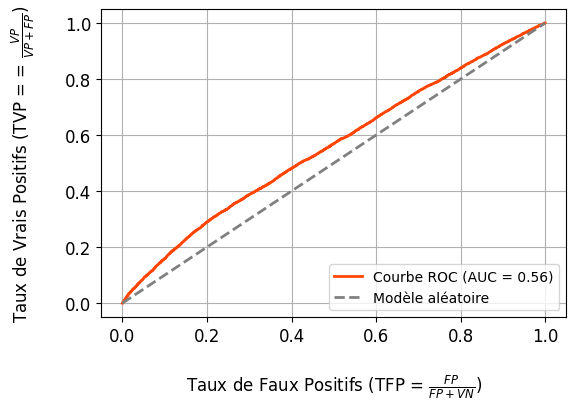

In [19]:
TVP_C1 = 0.1232
TFP_C1 = 0.0005

TVP_C2 = 0.0504
TFP_C2 = 0.0012

ROCcurve(y_test, Proba_test, "Amas")
#ROCcurve(y_test, Proba_test, "Amas", TFP_C1, TVP_C1, TFP_C2, TVP_C2, True)

In [14]:
def plot_precision_recall_curve(y_true, y_scores, NatureOfSource,
                               recall_C1=None, precision_C1=None,
                               recall_C2=None, precision_C2=None,
                               log=False):
    """
    Trace une courbe de précision/rappel avec options pour afficher des lignes
    correspondant aux valeurs de TVP (recall) et pureté (precision) pour C1 et C2.

    Args:
        y_true: Vecteur des vraies classes
        y_scores: Vecteur des scores
        NatureOfSource: Classe à considérer comme positive
        recall_C1: Valeur de recall pour la 1ère ligne verticale (optionnel)
        precision_C1: Valeur de precision pour la 1ère ligne horizontale (optionnel)
        recall_C2: Valeur de recall pour la 2ème ligne verticale (optionnel)
        precision_C2: Valeur de precision pour la 2ème ligne horizontale (optionnel)
        log: Si True, utilise une échelle logarithmique pour l'axe x
    """
    DicoOfLabels = {"Non amas": 0, "Amas":1}

    # Binariser y_true pour la classe cible
    y_true_bin = (y_true == DicoOfLabels[NatureOfSource]).astype(int)

    # Probabilités pour la classe cible
    y_scores_bin = y_scores[:, DicoOfLabels[NatureOfSource]]

    # Calcul de la courbe de précision/rappel
    precision, recall, thresholds = precision_recall_curve(y_true_bin, y_scores_bin)
    avg_precision = average_precision_score(y_true_bin, y_scores_bin)

    # Tracer la courbe
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'Courbe du Transformer')  # (AP = {avg_precision:.2f})

    # Ligne horizontale pour la proportion de positifs
    prevalence = np.mean(y_true_bin)
    plt.axhline(y=prevalence, color='gray', linestyle='--', label=f'Précision aléatoire: {prevalence:.2f}')

    # Couleurs cohérentes
    color_c1 = 'darkred' #'darkgreen'
    color_c2 = 'blue'

    # Trouver les intersections avec la courbe PR
    def find_intersections(target_precision):
        # Trouve tous les points où la courbe croise la ligne de pureté
        crossings = np.where(np.diff(np.sign(precision - target_precision)))[0]
        points = []
        for cr in crossings:
            x1, x2 = recall[cr], recall[cr+1]
            y1, y2 = precision[cr], precision[cr+1]
            # Interpolation linéaire pour trouver le recall exact
            x_interp = x1 + (target_precision - y1) * (x2 - x1) / (y2 - y1)
            points.append((x_interp, target_precision))
        return points

    # Pureté C1
    if precision_C1 is not None:
        plt.axhline(precision_C1, color=color_c1, ls='--',
                   label=f'Pureté C1 = {precision_C1:.2f}')
        intersections = find_intersections(precision_C1)
        for x, y in intersections:
            plt.plot(x, y, 'o', color=color_c1) #, label=f'A la pureté C1 = {y:.2f}: complétude = {x:.2f}'

    # Pureté C2
    if precision_C2 is not None:
        plt.axhline(precision_C2, color=color_c2, ls='--',
                   label=f'Pureté C2 = {precision_C2:.2f}')
        intersections = find_intersections(precision_C2)
        compteur = 0
        for x, y in intersections:
            if(compteur==0):
              plt.plot(x, y, 'o', color=color_c2)#, label=f'A la pureté C2 = {y:.2f}: complétude = {x:.2f}'
              compteur=+1

    if recall_C1 is not None:
        plt.axvline(recall_C1, color=color_c1, linestyle='--',
                   label=f'Complétude C1 = {recall_C1:.2f}')
    if recall_C2 is not None:
        plt.axvline(recall_C2, color=color_c2, linestyle='--',
                      label=f'Complétude C2 = {recall_C2:.2f}')

    if log:
        plt.xscale('log')

    plt.xlabel(r' Complétude = $\frac{VP}{VP+FN}$', fontsize = 20, labelpad = 20)
    plt.ylabel(r' Pureté = $\frac{VP}{VP+FP}$', fontsize = 20, labelpad = 20)
    autres = [k for k in DicoOfLabels if k != NatureOfSource]
    #plt.title(f"Courbe Précision-Rappel - Classe {NatureOfSource} (vs {' + '.join(autres)})")
    plt.legend(loc='best', fontsize=15)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.savefig(f'/local/home/sh275430/Documents//Results_Project_Transformer_FornaX/Center_classifier/PrecisionRecall_{NatureOfSource}.png',
               dpi=300, bbox_inches='tight')
    plt.show()

    # Ajouter cette section après le calcul de la courbe PR
    if precision_C1 is not None or precision_C2 is not None:
        print(" ")
        # Créer une fonction pour trouver le seuil avec le rappel le plus élevé
        def find_highest_recall_threshold(target_precision):
            # Trouver toutes les intersections
            intersections = find_intersections(target_precision)
            if not intersections:
                return None
            # Prendre l'intersection avec le rappel le plus élevé
            best_x, best_y = max(intersections, key=lambda item: item[0])
            # Trouver l'index le plus proche dans recall
            idx = np.argmin(np.abs(recall - best_x))
            return thresholds[idx]  # Retourne le seuil correspondant

        if precision_C1 is not None:
            threshold_C1 = find_highest_recall_threshold(precision_C1)
            if threshold_C1 is not None:
                print(f"Seuil pour pureté C1 ({precision_C1:.2f}): {threshold_C1:.4f}")

        if precision_C2 is not None:
            threshold_C2 = find_highest_recall_threshold(precision_C2)
            if threshold_C2 is not None:
                print(f"Seuil pour pureté C2 ({precision_C2:.2f}): {threshold_C2:.4f}")

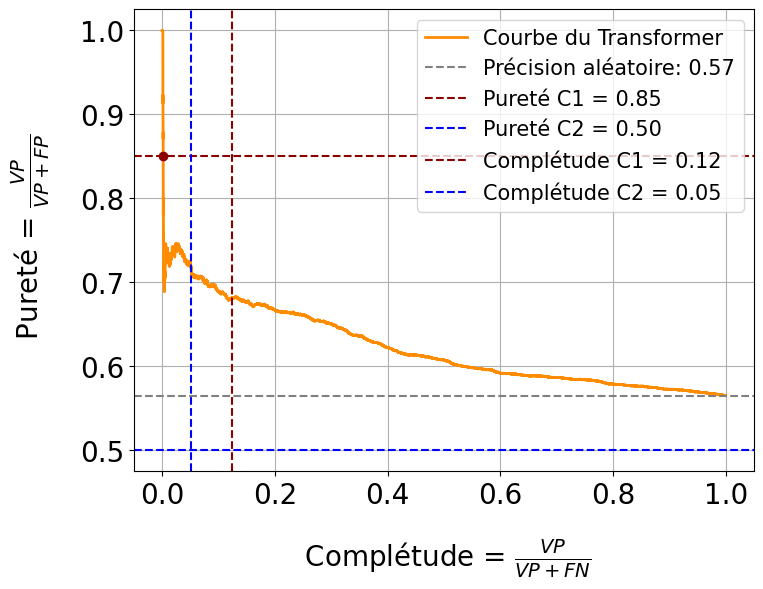

 
Seuil pour pureté C1 (0.85): 0.9867


In [15]:
purete_C1 = 0.85
purete_C2 = 0.5

plot_precision_recall_curve(y_test, Proba_test, "Amas",
                            recall_C1 = TVP_C1,
                            precision_C1 = purete_C1,
                            recall_C2 = TVP_C2,
                            precision_C2 = purete_C2)

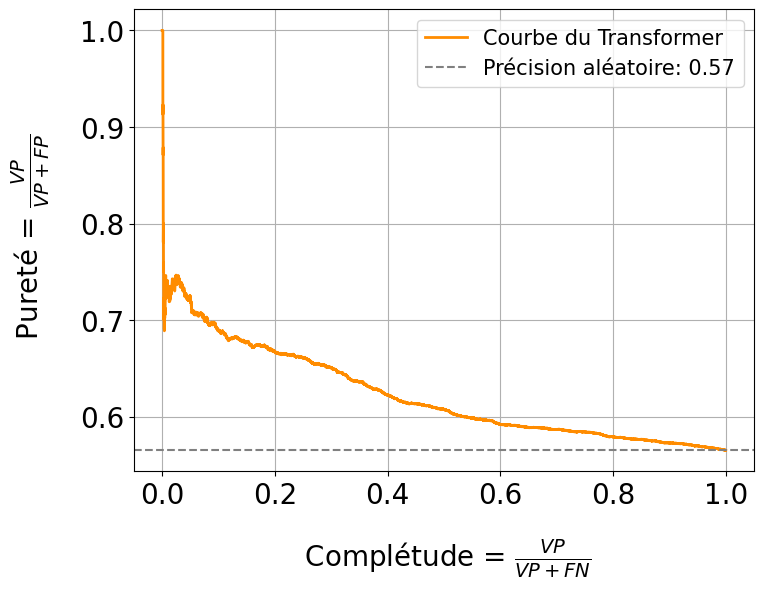

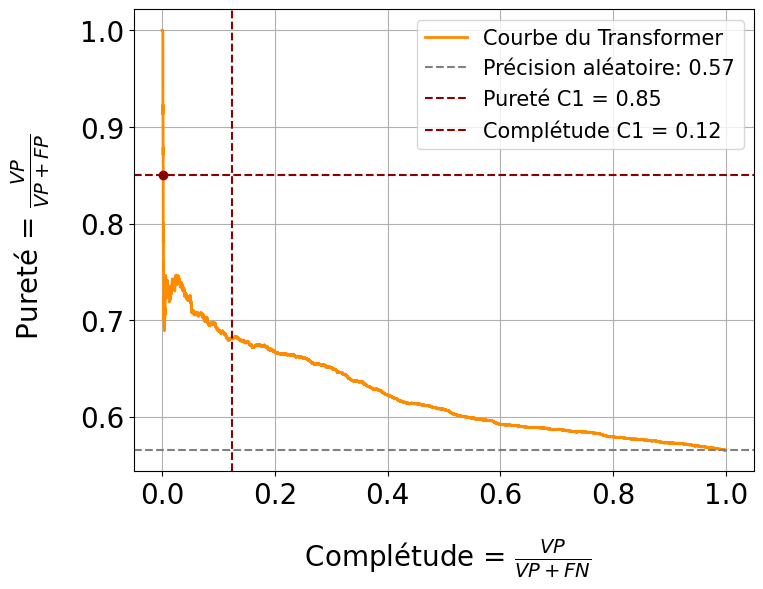

 
Seuil pour pureté C1 (0.85): 0.9867


In [16]:
plot_precision_recall_curve(y_test, Proba_test, "Amas")

plot_precision_recall_curve(y_test, Proba_test, "Amas",
                            recall_C1 = TVP_C1,
                            precision_C1 = purete_C1)